In [0]:
!pip install --upgrade -q gspread PyDrive

## Import libraries and methods

In [0]:
import math
import os
import string
import numpy
from datetime import datetime
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import statsmodels
import sklearn
from pandas import Grouper
from pandas import DataFrame
from pandas import concat
from pandas import Series
from math import sqrt
from math import log
from math import exp
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox

#  忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  

pd.set_option('display.float_format', lambda x: '%.4f' % x)

from imblearn.over_sampling import SMOTE
import itertools

#Goole Drive libs configuration
from oauth2client.client import GoogleCredentials
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import gspread
#@title Authenticate Google Drive client && create local directory
auth.authenticate_user()
credential = GoogleCredentials.get_application_default()
#iniate Google Spread Sheet
gc = gspread.authorize(credential)
#iniate Google Drive
gauth = GoogleAuth()
gauth.credentials = credential
drive = GoogleDrive(gauth)


def importfile(file_id='0Bxfl1AFkt6bcbFZXU1phSEJnVEE'):
    f = drive.CreateFile({'id': file_id})
    print('Drive file (title: %s, id: %s)' % (f['title'], f['id']))
    fname = os.path.join(os.getcwd(), f['title'])
    print('file path: {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
    return fname

def exportfile(file_name="sample.txt"):
    uploaded = drive.CreateFile({'title':file_name})
    uploaded.Upload()
    print('file {} uploaded to Google Drive'.format(file_name))
    
def create_dir(dir_name="Sample"):
  dir_path=os.path.join(os.getcwd(),dir_name)
  if not os.path.exists(dir_path):
    os.makedirs(dir_name)
  return dir_path


CWD=os.getcwd()
print("Current root dir: ",CWD)

Current root dir:  /content


## Import timeseries dataset

In [0]:
timeseries = importfile(file_id = '1bx2sY8TGrJ7DVRoZ_yjXxp3tQgqn4Zix')

Drive file (title: timeseries.csv, id: 1bx2sY8TGrJ7DVRoZ_yjXxp3tQgqn4Zix)
file path: /content/timeseries.csv


## Family choose

In [0]:
from pandas import read_csv
df = read_csv('timeseries.csv', index_col=2, header = 0, parse_dates=True, squeeze=True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

daily_summary = pd.DataFrame()
series = pd.DataFrame()
ids = df.dataid.unique().tolist()

for id in ids:
  daily_summary_id = df[df['dataid'] == id]
  daily_summary['dataid'] = daily_summary_id.dataid.resample('D').max()
  daily_summary['use'] = daily_summary_id.use.resample('D').sum()
  daily_summary['label'] = daily_summary_id.label.resample('D').max()
  series = series.append(daily_summary)
series.dropna(inplace = True)

print('There are totally 76 families, please enter which family you want to predict:')
x = int(input('Enter family number:'))
series = series[series['dataid'] == ids[x-1]]['use']
print("Number %d family's dataid is %d"%(x,ids[x-1]))

There are totally 76 families, please enter which family you want to predict:
Enter family number:1
Number 1 family's dataid is 410


## 1. Test Harness
1. Defining a Validation Dataset.
2. Developing a Method for Model Evaluation.

In [0]:
split_point = len(series) - 68
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 297, Validation 68


## 2. Persistence

In [0]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=44.342, Expected= 55
>Predicted=54.926, Expected= 42
>Predicted=41.537, Expected= 35
>Predicted=34.972, Expected= 39
>Predicted=38.513, Expected= 26
>Predicted=26.433, Expected= 37
>Predicted=36.868, Expected= 42
>Predicted=41.871, Expected= 36
>Predicted=36.176, Expected= 58
>Predicted=57.677, Expected= 49
>Predicted=49.264, Expected= 32
>Predicted=32.099, Expected= 31
>Predicted=30.943, Expected= 53
>Predicted=53.306, Expected= 42
>Predicted=42.255, Expected= 42
>Predicted=41.685, Expected= 57
>Predicted=57.261, Expected= 24
>Predicted=24.030, Expected= 27
>Predicted=27.211, Expected= 49
>Predicted=49.295, Expected= 56
>Predicted=56.257, Expected= 36
>Predicted=36.278, Expected= 41
>Predicted=40.566, Expected= 27
>Predicted=27.078, Expected= 36
>Predicted=35.730, Expected= 32
>Predicted=32.269, Expected= 30
>Predicted=29.892, Expected= 63
>Predicted=63.418, Expected= 46
>Predicted=46.262, Expected= 24
>Predicted=24.325, Expected= 16
>Predicted=15.776, Expected= 19
>Predict

**Conclusion:** ConRunning the test harness prints the prediction and observation for each iteration of the test dataset. The example ends by printing the RMSE for the model. In this case, we can see that the persistence model achieved an RMSE of 12.701. This means that on average, the model was wrong by about 12 electrical usage for each prediction made.

## 3. Data Analysis
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.

### 3.1 Summary Statistics

In [0]:
print(series.describe())

count   365.0000
mean     22.3331
std      12.3356
min       0.5305
25%      12.7492
50%      19.6841
75%      29.8905
max      67.5307
Name: use, dtype: float64


**Conclusion:** The large spread in this series will likely make highly accurate predictions difficult if it is caused by random fluctuation (e.g. not systematic).

### 3.2 Line Plot

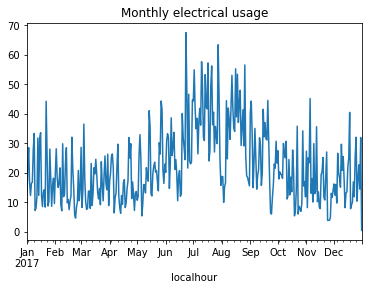

In [0]:
pyplot.title('Monthly electrical usage')
series.plot()
pyplot.show()

**Conclusion:** These simple observations suggest we may see benefit in modeling the trend and removing it from the time series. Alternately, we could use differencing to make the series stationary for modeling. We may even need two levels of differencing if there is a growth trend in the fluctuations in later months.

### 3.3 Density Plot

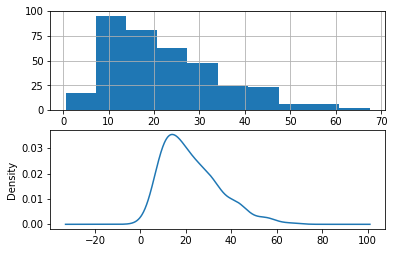

In [0]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

**Conclusion:**
1. The distribution is not Gaussian.
2. The distribution is left shifted and may be exponential or a double Gaussian.


### 3.4 Box and Whisker Plots

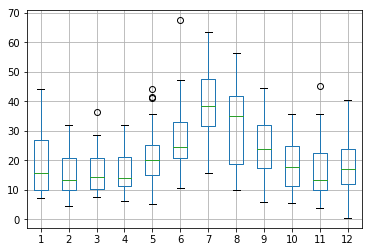

In [0]:
one_year = series['2017']
groups = one_year.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1) 
months = DataFrame(months)
months.columns = range(1, len(groups)+1)
months.boxplot()
pyplot.show()

**Conclusion:** The observations suggest that the month-to-month fluctuations may not be systematic and hard to model. This monthy view of the data is an interesting family electrical usage and could be pursued further by looking at summary statistics from month-to-month and changes in summary stats from month-to-month. Next, we can start looking at predictive models of the series.

## 4. ARIMA Models
We will approach this in four steps:
1. Developing a manually configured ARIMA model.
2. Using a grid search of ARIMA to find an optimized model.
3. Analysis of forecast residual errors to evaluate any bias in the model. 
4. Explore improvements to the model using power transforms.

### 4.1 Manually Configured ARIMA
Analysis of the time series data assumes that we are working with a stationary time series. The time series is almost certainly non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary. The example below creates a stationary version of the series and saves it to file stationary.csv.

In [0]:
# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return Series(diff) 
X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value)) # save
stationary.to_csv('stationary.csv')

ADF Statistic: -7.041553
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


**Conclusion:** Running the example outputs the result of a statistical significance test of whether the 1-lag differenced series is stationary. The results show that the test statistic value -8.763759 is smaller than the critical value at 5% of -2.872. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that the 1-lag differenced time series is stationary or does not have time-dependent structure.

This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1. The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.















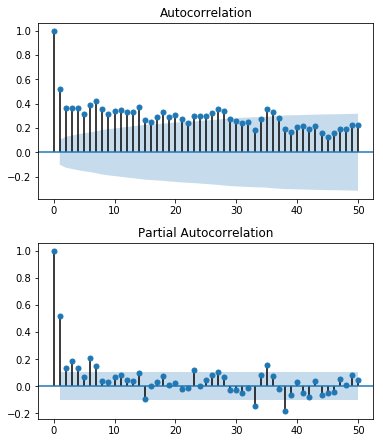

In [0]:
pyplot.figure(1)
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())

pyplot.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.25)

pyplot.figure(1)
pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

**Conclusion:** This quick analysis suggests an ARIMA(15,1,2) on the raw data may be a good starting point. The model can be simplified to ARIMA(0,1,2).

In [0]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%2.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=33.454, Expected=55
>Predicted=39.895, Expected=42
>Predicted=33.965, Expected=35
>Predicted=33.996, Expected=39
>Predicted=35.745, Expected=26
>Predicted=30.403, Expected=37
>Predicted=36.114, Expected=42
>Predicted=36.662, Expected=36
>Predicted=34.766, Expected=58
>Predicted=44.671, Expected=49
>Predicted=39.798, Expected=32
>Predicted=35.153, Expected=31
>Predicted=35.804, Expected=53
>Predicted=44.718, Expected=42
>Predicted=38.387, Expected=42
>Predicted=40.643, Expected=57
>Predicted=46.917, Expected=24
>Predicted=32.652, Expected=27
>Predicted=37.158, Expected=49
>Predicted=43.823, Expected=56
>Predicted=45.462, Expected=36
>Predicted=37.862, Expected=41
>Predicted=41.922, Expected=27
>Predicted=35.168, Expected=36
>Predicted=39.996, Expected=32
>Predicted=36.848, Expected=30
>Predicted=36.482, Expected=63
>Predicted=49.397, Expected=46
>Predicted=40.281, Expected=24
>Predicted=34.821, Expected=16
>Predicted=31.879, Expected=19
>Predicted=32.535, Expected=19
>Predict

**Conclusion:** Running this example results in an RMSE of 10.716, which is lower than the persistence model. This is a good start, but we may be able to get improved results with a better configured ARIMA model.

### 4.2 Grid Search ARIMA Hyperparameters


*   p: 0 to 4.
*   d: 0 to 2.
*   q: 0 to 4.






In [0]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order): 
  # prepare training dataset
  X = X.astype('float32')
  train_size = int(len(X) * 0.50)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
      for d in d_values:
        for q in q_values:
          order = (p,d,q)
          try:
            rmse = evaluate_arima_model(dataset, order)
            if rmse < best_score:
              best_score, best_cfg = rmse, order 
            print('ARIMA%s RMSE=%.3f' % (order,rmse))
          except:
            continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
  
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=14.152
ARIMA(0, 0, 1) RMSE=12.419
ARIMA(0, 0, 2) RMSE=12.048
ARIMA(0, 0, 3) RMSE=11.863
ARIMA(0, 0, 4) RMSE=11.638
ARIMA(0, 1, 0) RMSE=12.727
ARIMA(0, 1, 1) RMSE=10.901
ARIMA(0, 1, 2) RMSE=10.716
ARIMA(0, 2, 0) RMSE=20.992
ARIMA(0, 2, 1) RMSE=12.783
ARIMA(1, 0, 0) RMSE=11.531
ARIMA(1, 1, 0) RMSE=11.826
ARIMA(1, 1, 1) RMSE=10.651
ARIMA(1, 1, 2) RMSE=10.794
ARIMA(1, 1, 3) RMSE=10.902
ARIMA(1, 2, 0) RMSE=16.742
ARIMA(2, 0, 0) RMSE=11.427
ARIMA(2, 1, 0) RMSE=11.648
ARIMA(2, 1, 1) RMSE=10.802
ARIMA(2, 1, 2) RMSE=10.842
ARIMA(2, 1, 3) RMSE=10.974
ARIMA(2, 2, 0) RMSE=15.477
ARIMA(3, 0, 0) RMSE=11.294
ARIMA(3, 1, 0) RMSE=11.326
ARIMA(3, 1, 1) RMSE=10.840
ARIMA(3, 1, 2) RMSE=10.894
ARIMA(3, 2, 0) RMSE=14.266
ARIMA(4, 0, 0) RMSE=11.165
ARIMA(4, 1, 0) RMSE=11.250
ARIMA(4, 1, 1) RMSE=10.920
ARIMA(4, 2, 0) RMSE=13.876
Best ARIMA(1, 1, 1) RMSE=10.651


**Conclusion:** The results show that the best configuration discovered was ARIMA(1,1,1) with lowest RMSE = 10.651.

### 4.3 Review Residual Errors
A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by plotting the residuals with a histogram and density plots.

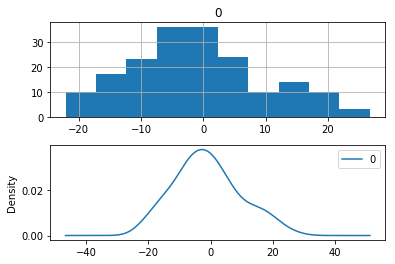

In [0]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca()) 
pyplot.subplot(212) 
residuals.plot(kind='kde', ax=pyplot.gca()) 
pyplot.show()

**Conclusion:** The graphs suggest a Gaussian-like distribution with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case that perhaps a power-based transform of the raw data before modeling might be useful.

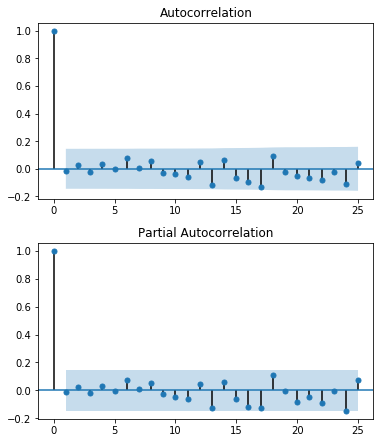

In [0]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(1,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())

pyplot.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=0.25)

pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

**Conclusion:** The results suggest that what little autocorrelation is present in the time series has been captured by the model.

### 4.4 Box-Cox Transformed Dataset
The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data.

Lambda: 0.310415


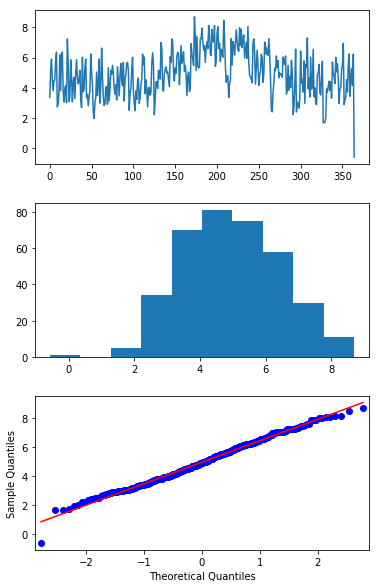

In [0]:
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=0.25)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca()) 
pyplot.show()                                

**Conclusion:** Running the example creates three graphs: a line chart of the transformed time series, a histogram showing the distribution of transformed values, and a Q-Q plot showing how the distribution of values compared to an idealized Gaussian distribution. Some observations from these plots are follows:


*   The large fluctuations have been removed from the line plot of the time series.
*   he histogram shows a flatter or more uniform (well behaved) distribution of values.
*   The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.





The boxcox() function used in the example finds an ideal lambda value by optimizing a cost function. 

In [0]:
# invert box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(1,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam) 
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%2.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)
                                  

>Predicted=31.314, Expected=55
>Predicted=34.426, Expected=42
>Predicted=32.600, Expected=35
>Predicted=31.459, Expected=39
>Predicted=32.835, Expected=26
>Predicted=29.460, Expected=37
>Predicted=32.692, Expected=42
>Predicted=34.477, Expected=36
>Predicted=33.449, Expected=58
>Predicted=39.251, Expected=49
>Predicted=38.505, Expected=32
>Predicted=34.199, Expected=31
>Predicted=33.752, Expected=53
>Predicted=40.145, Expected=42
>Predicted=38.160, Expected=42
>Predicted=38.424, Expected=57
>Predicted=42.999, Expected=24
>Predicted=33.372, Expected=27
>Predicted=33.985, Expected=49
>Predicted=40.523, Expected=56
>Predicted=42.994, Expected=36
>Predicted=38.286, Expected=41
>Predicted=39.653, Expected=27
>Predicted=35.132, Expected=36
>Predicted=37.761, Expected=32
>Predicted=36.580, Expected=30
>Predicted=35.548, Expected=63
>Predicted=44.518, Expected=46
>Predicted=41.466, Expected=24
>Predicted=34.453, Expected=16
>Predicted=29.439, Expected=19
>Predicted=29.791, Expected=19
>Predict

**Conclusion:** The final RMSE of the model on the transformed data was 10.476. This is a smaller error than the ARIMA model on untransformed data, but only slightly, and it may or may not be statistically different.

## 5. Model Validation


*   **Finalize Model:** Train and save the final model.
*   **Make Prediction:** Load the finalized model and make a prediction.
*   **Validate Model:** Load and validate the final model.




### 5.1 Finalize Model
The code below fits an ARIMA(1,1,1) model on the Box-Cox transform dataset and saves the whole fit object and the lambda value to file.

In [0]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(1,1,1)) 
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl') 
numpy.save('model_lambda.npy', [lam])
!ls

adc.json     model_lambda.npy  sample_data     timeseries.csv
dataset.csv  model.pkl	       stationary.csv  validation.csv


Conclusion: 
*   model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
*   model lambda.npy This is the lambda value stored as a one-row, one-column NumPy
array.



### 5.2 Make Prediction

Predicted: 7.576


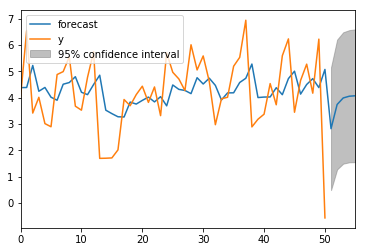

In [0]:
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# invert box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)
model_fit = ARIMAResults.load('model.pkl') 
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam) 
print('Predicted: %.3f' % yhat)

model_fit.plot_predict(len(train)-50, 
                       len(train)+5) 
pyplot.legend(loc='upper left')
pyplot.show()

**Conclucion:** The plot predict() function will plot the observed y values if the prediction interval covers the training data. In this case, we predict the previous 50 days and the next 5 day. This is useful to see the prediction carry on from in sample to out of sample time indexes. This is contracted with the actual observations from the last 50 days. Finally, we can see the confidence interval as a gray cone around the predicted value. This is useful to get a spatial feeling for the range of possible values that an observation in the next time step may take.

### 5.3 Validate Model

>Predicted=7.576, Expected=  8
>Predicted=11.702, Expected= 7
>Predicted=11.422, Expected=10
>Predicted=12.476, Expected=34
>Predicted=21.819, Expected=16
>Predicted=12.948, Expected=17
>Predicted=16.556, Expected=12
>Predicted=12.942, Expected=27
>Predicted=20.448, Expected= 8
>Predicted=10.659, Expected=25
>Predicted=20.473, Expected=23
>Predicted=16.803, Expected=45
>Predicted=25.156, Expected=13
>Predicted=13.868, Expected=18
>Predicted=18.750, Expected=10
>Predicted=13.602, Expected=30
>Predicted=22.328, Expected=13
>Predicted=14.394, Expected=14
>Predicted=16.428, Expected=36
>Predicted=22.922, Expected=10
>Predicted=13.412, Expected=14
>Predicted=16.798, Expected= 8
>Predicted=12.930, Expected= 8
>Predicted=12.958, Expected=19
>Predicted=17.299, Expected=20
>Predicted=16.497, Expected=25
>Predicted=18.668, Expected=12
>Predicted=13.768, Expected=11
>Predicted=14.325, Expected=19
>Predicted=16.955, Expected=27
>Predicted=19.013, Expected= 4
>Predicted=9.427, Expected= 4
>Predicte

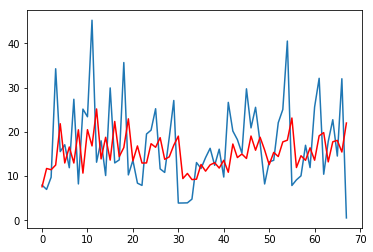

In [0]:
# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam) 
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0])) # rolling forecasts
for i in range(1, len(y)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%2.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions)) 
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red') 
pyplot.show()

**Conclusion:** A plot of the predictions compared to the validation dataset is also provided. The forecast does have the characteristic of a persistence forecast. This does suggest that although this time series does have an obvious trend, it is still a reasonably difficult problem.